In [5]:
import pandas as pd
import numpy as np

# Reading our csv data
dados = pd.read_csv('dados 40k.csv')

X = dados.drop('R10', axis=1)

target_column = ['R10'] #criar a coluna target para o y
predictors = list(set(list(dados.columns))-set(target_column)) #retirar a coluna target e ficar apenas com as features, x
#dados[predictors] = dados[predictors]/dados[predictors].max() #normalização das unidades, outra forma não utilizada

#dados.describe()

#criar o conjunto de dados de treino e de teste, pois não estavam em colunas
X = dados[predictors].values
y = dados[target_column].values

dados.head()

,K_sat,Q_sat,Z_sat,E_sym,L_sym,K_sym,Q_sym,Z_sym,R10
0,227.171398,88.768968,-179.115601,28.109773,70.713317,-176.966916,224.419874,656.524971,12.600000
1,232.589005,132.098105,-167.056538,32.743075,85.060572,-114.273255,-84.254912,730.292564,12.701489
2,210.963869,351.461450,-523.245991,33.692041,49.685094,-87.522249,237.409814,-208.489208,12.404865
3,244.329171,157.304519,-286.615934,33.500592,53.203060,4.410613,-113.367538,218.245650,12.579676
4,185.028601,153.106499,-247.680638,34.209498,73.918805,-139.897289,-51.679093,918.078659,12.260222


Primeiramente, depois de importar os dados utilizando o comando pd.read_csv, separaram-se os dados relativos ao raio, o nosso y, que será a coluna alvo. Todas as restantes colunas serão os vários parâmetros x, que servirão para prever o y. 


In [6]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)


Agora, com os dados importados, podemos Scomeçar os vários métodos de treino e teste para implementar as Decision Trees.
Nesta primeira fase, pretendeu-se construir uma decision tree, sem a otimização dos parâmetros da função DecisionTreeRegressor, com o objetivo de estudar o efeito da otimização dos mesmos nos resultados finais.

In [9]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X_train)
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

X_train

array([[-1.15635235, -0.52888439,  0.71890326, ...,  1.35769258,
        -1.67479256, -0.30648178],
       [ 0.49170312, -1.19248019,  0.93154557, ..., -1.20557815,
         0.75025959,  1.31831765],
       [-1.99354553, -1.04921926,  0.81499513, ..., -1.70420204,
         0.87983944, -0.42627916],
       ...,
       [ 0.1134122 , -0.52916423,  0.66332793, ...,  0.73199616,
         1.88253035, -0.25065537],
       [-0.17832715,  0.84337274, -0.44726764, ..., -0.53026409,
         0.28388689, -0.02901212],
       [ 0.17133019, -0.20083147,  0.13072011, ...,  0.42457065,
        -0.65152104,  1.01742252]])

É de notar que antes de proceder a qualquer implementação do modelo, é necessária uma normalização às unidades de todos os dados. Para isto, usou-se a função StandardScaler, que normaliza as propriedades colocadas na função, subtraindo às amostras a média e escalonando-se relativamente à variância da unidade. O resultado aproximar-se-á a uma distribuição normal gaussiana centrada em 0 e com variância igual à unidade.

In [8]:
# tamanho do conjunto de dados de treino
X_train.shape

(30000, 8)

In [145]:
# tamanho do conjunto de dados de teste
X_test.shape

(10000, 8)

C:\Users\User\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


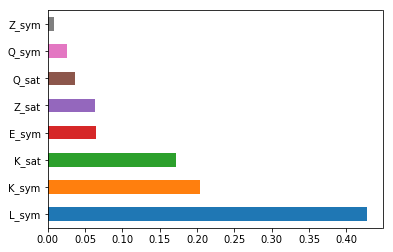

In [146]:
#Extra: encontrar valores, parâmetros cuja importância é maior para o modelo

import matplotlib.pyplot as plt
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score as acc

#aqui o split está feito de outra forma para testar 
X_train, X_test, y_train, y_test = train_test_split(dados.iloc[:,:-1], dados.iloc[:,-1], test_size = 0.25, random_state = 0)

extra = ExtraTreesRegressor() #classe: encontra os parâmetros mais importantes

extra.fit(X_train,y_train)

#print da importância dos parâmetros
extra.feature_importances_

feat_importances = pd.Series(extra.feature_importances_, index = X_train.columns) #a função Series apenas aceita colunas
feat_importances.nlargest(8).plot(kind = 'barh')
plt.show()

Para além da implementação do modelo, é importante estudar a importância, o peso de cada parâmetro, no cálculo do valor do raio R10. Assim, procedeu-se a um split, para formar conjuntos de dados de teste e de treino e usou-se a classe ExtraTreesRegressor. Esta classe encontra os parâmetros mais importantes, implementando um estimador meta que ajusta decision trees aleatórias, extra-trees, a várias sub-amostras dos dados. Usa médias para otimizar a eficácia da previsão e o controlo de over-fitting.
Fez-se o fit aos dados de treino e representaram-se as várias importâncias percentuais num gráfico de barras. Daqui, verificou-se que os parâmetros com mais importância são o L_sym, o K_sym e o K_sat.

In [147]:
# Gini Importance ou Mean Decrease in Impurity (MDI)
#número de vezes que a feature é usada para dar split a um nó, tendo em conta o numero de amostras que divide.
#Calcula a importância de cada parâmetro como a soma do número de divisões, splits, (no total das trees) 
#que incluem esse parâmetro, proporcionalmente ao número de amostras que esse parâmetro divide.
#A diminuição da node impurity é somada e é feita a média pelo total das trees. 

In [2]:
# Traning model with all features 

from sklearn.model_selection import train_test_split

#divisão com 25% dos dados para teste
X_train, X_test, y_train, y_test = train_test_split(dados.iloc[:,:-1], dados.iloc[:,-1], test_size = 0.25, random_state = 0)

#visualização dados treino e teste
#X_train
#X_test

NameError: name 'dados' is not defined

Com a normalização feita, vamos agora fazer de novo um split, através da função train_test_split, onde 75% dos dados serão armazenados como dados de treino e o resto como dados de teste. 

In [150]:
#dados teste
X_test

,K_sat,Q_sat,Z_sat,E_sym,L_sym,K_sym,Q_sym,Z_sym
12836,249.035799,36.277868,-121.881204,28.611336,40.239254,-88.252165,361.094335,-354.110257
10913,229.930362,-121.067426,28.800788,33.261380,76.097753,36.054762,-343.860441,389.311071
4214,255.555618,-7.572342,-69.231639,31.302686,65.241391,-91.390823,195.938899,241.646737
8198,225.028325,27.504570,-139.449905,33.287862,62.373814,-109.546580,507.318291,-658.409990
31403,218.881444,-114.240239,47.016619,32.157162,70.347108,75.626417,194.382888,-197.035278
13917,250.303843,-129.885165,40.851417,34.189569,68.994352,7.407975,405.125325,261.065879
27440,230.638782,-184.714014,176.274473,30.373797,41.109259,-65.560424,-73.176330,377.877310
11667,222.730845,-15.205561,-58.735474,34.336265,71.573601,76.199902,395.618007,231.665459
29616,242.715103,-76.925206,-35.502318,28.814337,46.360199,-145.802312,313.510577,-130.391396
39864,254.884807,-55.009799,-50.812273,32.406981,42.480204,-81.400112,620.544214,177.019534


In [151]:
from sklearn.tree import DecisionTreeRegressor

#implementação do modelo decision tree e fit ao conjunto de dados
d_tree = DecisionTreeRegressor()

#ajusta as variáveis independentes às variáveis dependentes
d_tree.fit(X_train,y_train)

#avaliação do modelo de regressão - dados de treino
d_tree.score(X_train,y_train)


0.9999999667489995

Agora, estando em condições de construir a decision tree. Implementado o modelo, podemos ajustar os dados de treino, as variáveis independentes, à decision tree. A seguir, calculou-se o "score", a pontuação, deste modelo de regressão aplicado aos dados de treino e o "score" deste modelo de regressão aplicado aos dados de teste. A pontuação do modelo será a precisão média face aos dados de teste ou treino, respetivamente.

In [152]:
#avaliação do modelo de regressão - dados de teste
d_tree.score(X_test,y_test)

0.8828545789648694

C:\Users\User\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


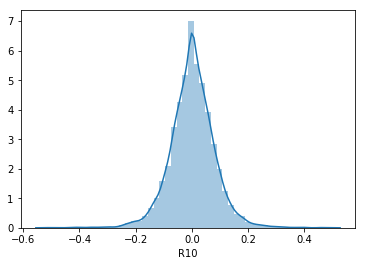

In [153]:
import seaborn as sns
#seaborn é outra libraria de Python baseada em matplotlib, de visualização de dados estatísticos. Mais avançada.
 
prediction_test = d_tree.predict(X_test)

#diferença entre R10 registado e previsto
sns.distplot(y_test-prediction_test)


Com a previsão realizada, vamos agora visualizar se os dados previstos para o raio seguem uma distribuição semelhante ao dos dados registados do raio. Utilizando a library seaborn, fazemos o plot da distribuiçã da diferença de valores dos dados do raio e dos dados previstos. Como se verifica na figura, a distribuição é bastante coincidente com a curva, o que nos diz que o intervalo de valores previstos é próximo do intervalo de valores registados.

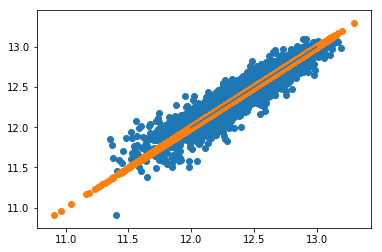

In [154]:
#com distribuição de pontos
n_samples_train = len(y_train)
n_samples_test = len(y_test)

prediction_train = d_tree.predict(X_train)

plt.plot([12, 13],[12, 13])

plt.scatter(y_test,prediction_test)
plt.scatter(y_train,prediction_train)
plt.show()

Noutra perspetiva, podemos analisar num gráfico de distribuição de pontos que, representando os valores dos dados de previsão de teste em função dos raios verdadeiros de teste e os valores dos dados de previsão de treino em função dos raios verdadeiros de treino, verifica-se que seguem aproximadamente uma reta de declive y=x. A aproximação poderia ser melhor se a amostra fosse superior, esta foi com 40000 dados.

In [1]:
#Intervalo de valores para inicializar a hiperparametrização - tuning, calibração

parameters = {"splitter":["best","random"],
            "max_depth" : [1,3,5,7,9,11,12],
           "min_samples_leaf":[1,2,3,4,5,6,7,8,9,10],
           "min_weight_fraction_leaf":[0.1,0.2,0.3,0.4,0.5],
           "max_features":["auto","log2","sqrt",None],
           "max_leaf_nodes":[None,10,20,30,40,50,60,70,80,90] }


from sklearn.model_selection import GridSearchCV

tuning_model = GridSearchCV(d_tree, param_grid = parameters, scoring = 'neg_mean_squared_error',cv = 5, verbose = 3)

#cv splitter
#estratégia de splitting, como as iterações decorrem, 3-fold, 5-fold

#verbosity, quanto maior, mais mensagens serão mostradas
#>1 : the computation time for each fold and parameter candidate is displayed;
#>2 : the score is also displayed;
#>3 : the fold and candidate parameter indexes are also displayed together with the starting time of the computation.

NameError: name 'd_tree' is not defined

Posteriormente, ao contrário de anteriormente, fez-se outra decision tree- No entanto, desta vez, calcularam-se os melhores parâmetros para o modelo a serem colocados na regressão, na função DecisionTreeRegressor. 

Para isto, utilizou-se um algoritmo de hiperparametrização, com o comando GridSearchCV para ajustar, calibrar os melhores valores das métricas do estimador (d_tree) usados para aplicar os métodos de fit e score. Estes parâmetros são optimizados através de uma procura exaustiva de cross-validation sob um conjunto de parâmetros definidos previamente numa lista.

In [ ]:
#função para calcular quanto tempo o calclulo iterarivo dos parâmetros demorou 

def timer(start_time = None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour,temp_sec = divmod((datetime.now() - start_time).total_seconds(),3600)
        tmin,tsec = divmod(temp_sec,60)
        #print(thour,":",tmin,':',round(tsec,2))
        

Para uma melhor avaliação do modelo, queremos também considerar a componente temporal, quanto tempo demora, de facto, o processo de hiperparametrização. Assim, construiu-se esta pequena função com o objetivo de calcular o tempo que o processo de procura das métricas demorou.

In [ ]:
X = dados.iloc[:,:-1]
y = dados.iloc[:,-1]

#%%capture parameter
from datetime import datetime

start_time = timer(None)

tuning_model.fit(X,y)

timer(start_time)

# best hyperparameters 
tuning_model.best_params_

#parameter()

Começou-se então o processo de cálculo iterativo de GridSearchCV, com um método de fit e "score", que, neste caso, será igual ao erro MSE negativo. Escolheu-se uma verbosity de 3 e cv splitter igual a 5. Cada iteração tem o seguinte formato:

[CV]  max_depth=12, max_features=None, max_leaf_nodes=90, min_samples_leaf=10, min_weight_fraction_leaf=0.5, splitter=random, score=-0.05489630765589389, total=0.0s

Após 76.4min, o processo de procura terminou, tendo resultado os seguintes parâmetros:

d_tree_tuned = DecisionTreeRegressor(max_depth = 5,
                                         max_features = None,
                                         max_leaf_nodes = 70,
                                         min_samples_leaf = 10,
                                         min_weight_fraction_leaf = 0.1,
                                         splitter = 'best')

In [ ]:
d_tree_tuned = DecisionTreeRegressor(max_depth = 5,
                                         max_features = None,
                                         max_leaf_nodes = 70,
                                         min_samples_leaf = 10,
                                         min_weight_fraction_leaf = 0.1,
                                         splitter = 'best')



#outras tentativas
#d_tree_tuned = DecisionTreeRegressor(max_depth = 9,
                                         #max_features = None,
                                         #max_leaf_nodes = 60,
                                         #min_samples_leaf = 3,
                                         #min_weight_fraction_leaf = 0.1,
                                         #splitter = 'best')


#d_tree_tuned = DecisionTreeRegressor(max_depth = 3,
                                         #max_features = 'log2',
                                         #max_leaf_nodes = 80,
                                         #min_samples_leaf = 2,
                                         #min_weight_fraction_leaf = 0.1,
                                         #splitter = 'best')

#c/ 3 fold
#d_tree_tuned = DecisionTreeRegressor(max_depth = 11,
                                         #max_features = None,
                                         #max_leaf_nodes = 20,
                                         #min_samples_leaf = 4,
                                         #min_weight_fraction_leaf = 0.1,
                                         #splitter = 'random')

Utilizando os valores acima calculados, procedeu-se então à nova regressão, com as métricas calibradas.

In [ ]:
d_tree_tuned.fit(X_train,y_train)

tuned_prediction_test = d_tree_tuned.predict(X_test)
tuned_prediction_train = d_tree_tuned.predict(X_train)

plt.scatter(y_test,tuned_prediction_test)
plt.scatter(y_train,tuned_prediction_train)

#pk é que estão dispostos numa linha horizontal?
#de facto, o arranjo dos dados previstos neste modelo está mais próximo do de treino

Pondo em prática o modelo de regressão mais uma vez, construiu-se outra decision tree, com as novas métricas e ajustaram-se novamente os dados de treino, as variáveis independentes, à decision tree calibrada.

In [ ]:
#Resultados do modelo com parâmetros ajustados 

from sklearn import metrics
#from sklearn.metrics import r2_score

#root-mean-square error (RMSE)
#print(np.sqrt(mean_squared_error(y_test,pred_test_tree)))

#RMSE and R-squared value for regression tree on testing data

print('MAE:', metrics.mean_absolute_error(y_test,tuned_prediction_test))
print('MSE:', metrics.mean_squared_error(y_test, tuned_prediction_test))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, tuned_prediction_test)))
#print(r2_score(y_test, tuned_prediction_test))

Finalmente, calcularam-se os erros relacionados com o modelo sem parâmetros ajustados e o modelo com parâmetros ajustados.
O erro mais importante, que merece mais consideração, é o RMSE, ou seja, o root mean squared error. Este erro é uma forma de medir a diferença entre os valores previstos por um modelo e os valores verdadeiros registados. 

In [ ]:
#Resultados do modelo sem parâmetros ajustados

#RMSE and R-squared value for regression tree on testing data

print('MAE:', metrics.mean_absolute_error(y_test,prediction_test))
print('MSE:', metrics.mean_squared_error(y_test, prediction_test))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, prediction_test)))

In [ ]:
inversed_xtrain = sc.inverse_transform(X_train)
inversed_xtest = sc.inverse_transform(X_test)
#print(inversed_xtrain)
#print(inversed_xtest)

#R SQUARED
#avalia a dispersão de valores à volta da linha de regressão
#para o mesmo conjunto de dados, um R-squared elevado quer dizer que as diferenças entre os dados observados e 
#ajustados são pequenas

d_tree_tuned.score(X_train,y_train)
#0.47821531082460156

Paralelamente, calculou-se os valores finais do "score" do modelo com parâmetros ajustados, para comparar com o "score" do modelo anterior. Para isto, teve que se inverter a normalização feita no início do programa, pois o cálculo destas métricas finais não precisa da normalização das unidades.

In [ ]:
d_tree_tuned.score(X_test,y_test)
#0.26258152207530394

In [ ]:
# checking difference between labled y and predicted y
sns.distplot(y_test-tuned_prediction_test)

Por fim, visualizaram-se os dados previstos para o raio novamente, mas com as métricas da regressão calibradas. Verifica-se que seguem uma distribuição semelhante ao dos dados registados do raio. Utilizando a library seaborn, fez-se novemente o plot da distribuição da diferença de valores dos dados do raio e dos dados previstos. Como se verifica na figura, a distribuição é bastante coincidente com a curva, o que nos diz que o intervalo de valores previstos é próximo do intervalo de valores registados mais uma vez.